In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Question 4. Homography #

### 4.1 src ###

In [2]:
def get_3_channels_gray(img):
    """returns a 3-channel grayscale image"""
    gray_1_channel = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_3_channel = np.zeros_like(img)
    gray_3_channel[:, :, 0] = gray_3_channel[:, :, 1] = gray_3_channel[:, :, 2] = gray_1_channel
    return gray_3_channel

In [3]:
# Q4.2 src 
def get_homography(I_1_points, I_2_points):
    assert(len(I_1_points) == len(I_2_points))
    n = len(I_1_points)
    A = np.zeros((2 * n, 9))
    for i in range(n):
        x1, y1 = I_1_points[i]
        x2, y2 = I_2_points[i]
        A[2 * i, 0:3] = x1, y1, 1
        A[2 * i + 1, 3:6] = x1, y1, 1
        A[2 * i, 6:9] = -x2 * x1, -x2 * y1, -x2
        A[2 * i + 1, 6:9] = -y2 * x1, -y2 * y1, -y2
    u, s, vh = np.linalg.svd(A)
    smallest_eigen_idx = np.argmin(s)
    h = vh[smallest_eigen_idx, :]
    H = h.reshape(3, 3)
    return H

def get_mapped_coordinate(H, x, y):
    v = np.array([x, y, 1.])
    v_ = H @ v
    v_ = v_ / v_[2]
    return int(v_[0]), int(v_[1])

In [4]:
# Load images 
hallway1 = cv2.imread('./hallway1.jpg')
hallway1 = cv2.cvtColor(hallway1, cv2.COLOR_BGR2RGB)
hallway2 = cv2.imread('./hallway2.jpg')
hallway2 = cv2.cvtColor(hallway2, cv2.COLOR_BGR2RGB)
hallway3 = cv2.imread('./hallway3.jpg')
hallway3 = cv2.cvtColor(hallway3, cv2.COLOR_BGR2RGB)

def run_case(case):
    if case == 'A':
        # I_1_points = [(231, 1098), (145, 927), (285, 926), (448, 876), (237, 883)]
        # I_2_points = [(540, 948), (300, 920), (596, 790), (766, 753), (553, 740)]
        I_1_points = np.array([[732, 562], [729, 341], [1000, 86], [842, 653], [880, 451]])
        I_2_points = np.array([[604, 880], [595, 668], [849, 403], [704, 964], [744, 768]])
        img1, img2 = hallway1, hallway2
    elif case == 'B':
        I_1_points = np.array([[726, 553], [733, 339], [1000, 83], [999, 806], [944, 392]])
        I_2_points = np.array([[755, 748], [753, 529], [903, 274], [924, 983], [880, 589]])
        img1, img2 = hallway1, hallway3
    elif case == 'C':
        I_1_points = np.array([[498, 751], [573, 550], [729, 553], [959, 773], [610, 488]])
        I_2_points = np.array([[453, 943], [601, 751], [756, 745], [889, 961], [670, 680]])
        img1, img2 = hallway1, hallway3
    else:
        raise('Incorrect Case Letter')
    # canvas
    fig, axes = plt.subplots(2, 2, figsize=(25, 13))
    fig.suptitle(f'Case {case}')

    # Q4.1
    gray1 = get_3_channels_gray(img1)
    gray2 = get_3_channels_gray(img2)
    for x, y in I_1_points:
        cv2.rectangle(gray1, (x - 9, y - 9), (x + 9, y + 9), (255, 255, 0), 3)
    for x, y in I_2_points:
        cv2.rectangle(gray2, (x - 9, y - 9), (x + 9, y + 9), (255, 255, 0), 3)
    axes[0, 0].imshow(gray1, cmap='gray')
    axes[0, 0].set_title('I_1 Selected Points')
    axes[0, 1].imshow(gray2)
    axes[0, 1].set_title('I_2 Selected Points')
 
    # Q4.2
    H = get_homography(I_1_points, I_2_points)
    
    # Q4.3 src
    img2_cpy = img2.copy()
    for x, y in I_1_points:
        new_x, new_y = get_mapped_coordinate(H, x, y)
        cv2.rectangle(img2_cpy, (new_x - 9, new_y - 9), (new_x + 9, new_y + 9), (0, 255, 0), 3)
    for x, y in I_2_points:
        cv2.rectangle(img2_cpy, (x - 9, y - 9), (x + 9, y + 9), (255, 0, 0), 3)
    axes[1, 0].imshow(img2_cpy)
    axes[1, 0].set_title('4.3 Esimated Points')

    # Q4.4 src
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)
    from tqdm import tqdm
    padding_size = 500
    img3 = np.zeros((img1.shape[0] +  2 * padding_size, img1.shape[1] + 2 * padding_size, 3))
    img3[padding_size:padding_size + img1.shape[0], padding_size:padding_size + img1.shape[1], 0] = img1_gray
    for x in tqdm(range(img3.shape[0])):
        for y in range(img3.shape[1]):
            y_, x_ = get_mapped_coordinate(H, y, x) # note x, y is reversed
            if x_ >= padding_size and x_ < padding_size + img2_gray.shape[0] \
                and y_ >= padding_size and y_ < padding_size + img2_gray.shape[1]:
                img3[x, y, 1] = img2_gray[x_ - padding_size, y_ - padding_size]
                img3[x, y, 2] = img2_gray[x_ - padding_size, y_ - padding_size]
    img3 /= 255

    axes[1, 1].imshow(img3)
    axes[1, 1].set_title('4.4 Inverse Mapping')
    plt.show()
    return H

100%|██████████| 2000/2000 [00:34<00:00, 58.79it/s]


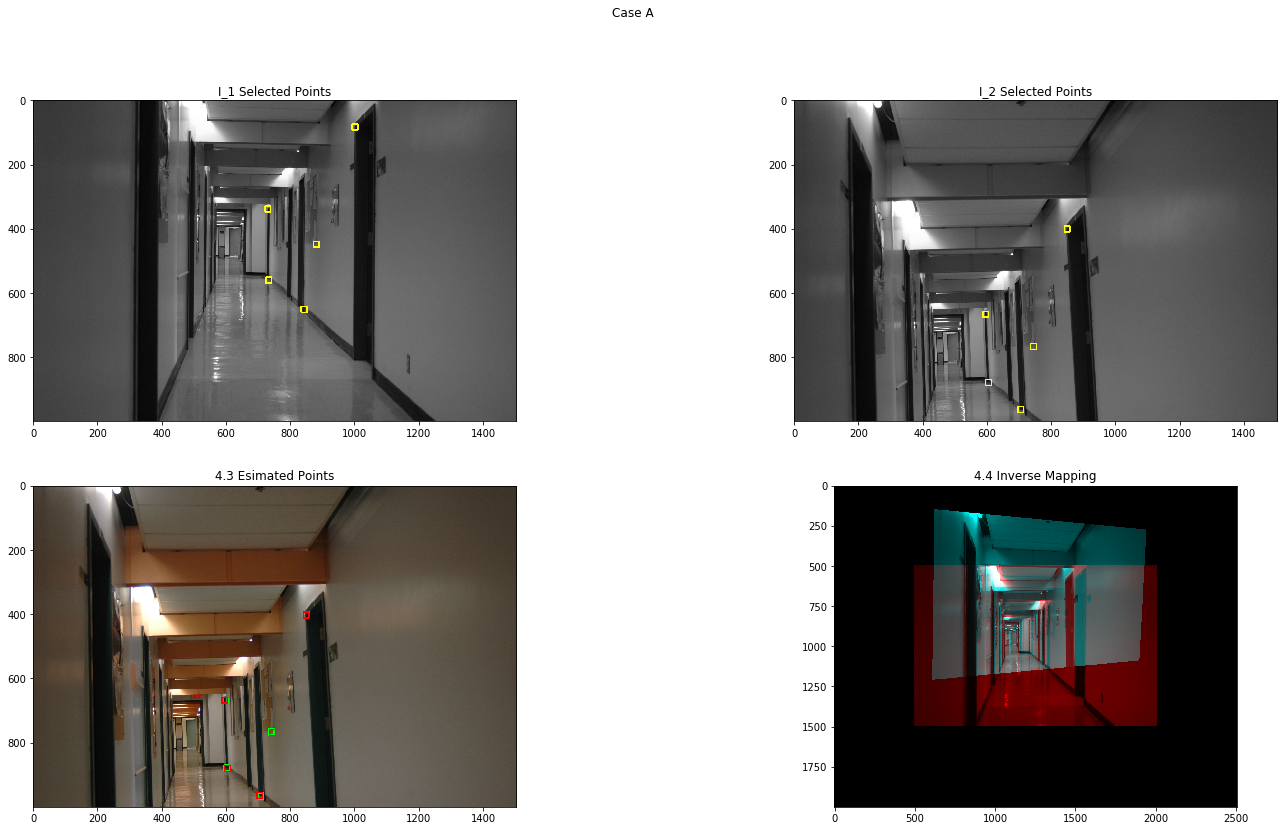

In [5]:
H = run_case('A')

In [6]:
H

array([[ 1.64649980e-03, -1.27879385e-05,  2.64626379e-02],
       [-3.68664754e-04,  1.87967222e-03,  9.99643866e-01],
       [-3.69695616e-07, -7.03373514e-08,  2.34294735e-03]])

The homography contains rotates and scale slightly with perspective transfomation 

100%|██████████| 2000/2000 [00:35<00:00, 56.92it/s]


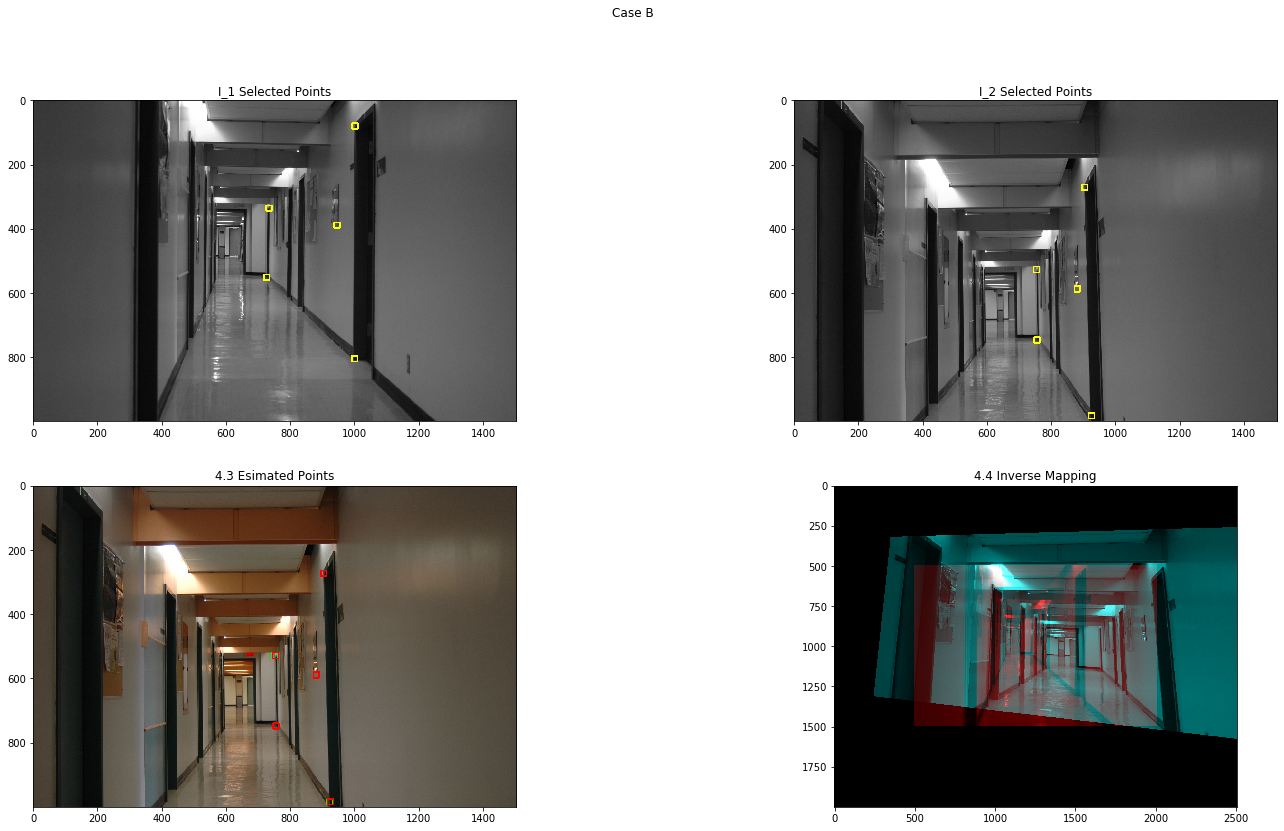

In [7]:
H = run_case('B')

In [8]:
H

array([[-3.63271055e-03, -5.98058705e-04, -8.97743706e-01],
       [-4.96612737e-04, -5.45622060e-03, -4.40447414e-01],
       [-6.99792339e-07, -4.91043652e-07, -4.32930200e-03]])

The homography does a scaling, perspective transformation.

100%|██████████| 2000/2000 [00:32<00:00, 62.28it/s]


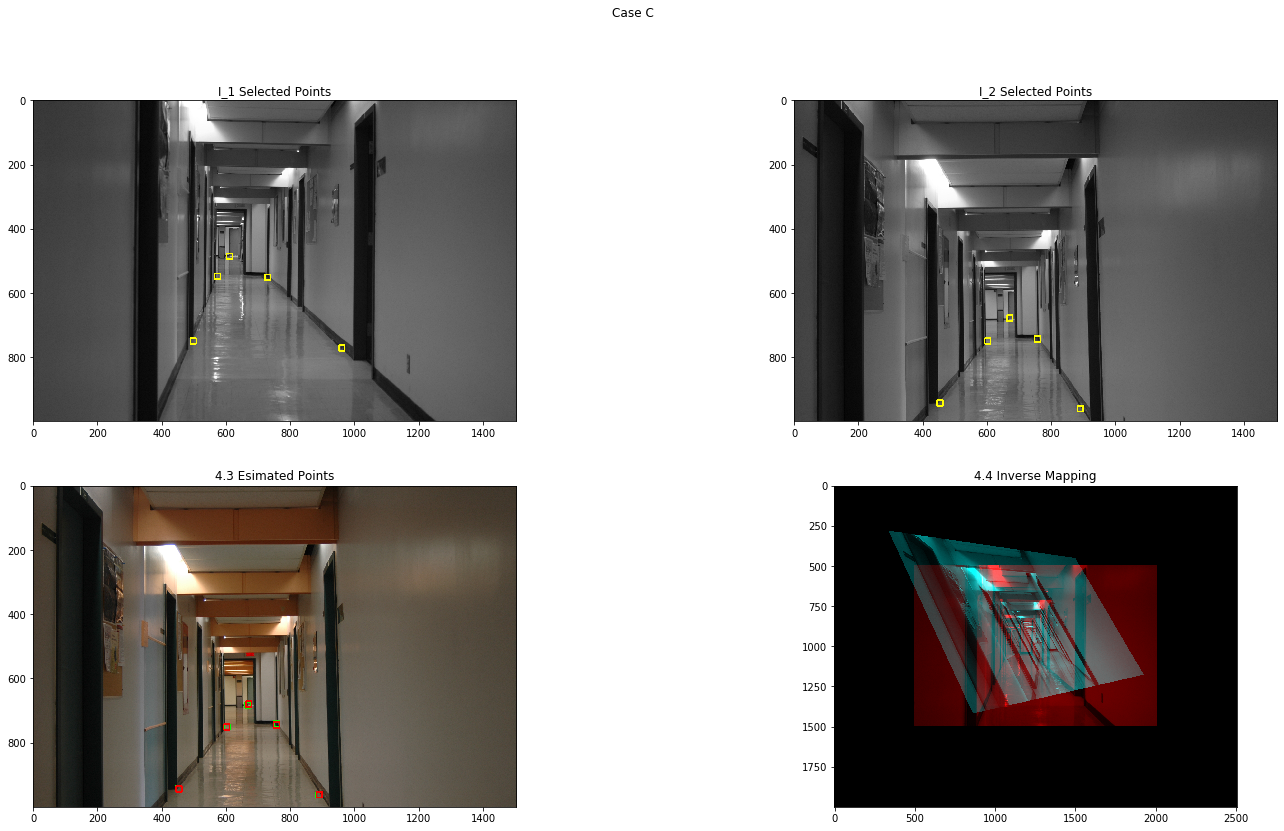

In [9]:
H = run_case('C')

In [10]:
H

array([[ 1.73705200e-03, -6.67108890e-04,  7.76760182e-01],
       [-7.63278620e-04,  2.83126788e-03,  6.29782215e-01],
       [-7.92016851e-07,  6.40670467e-07,  2.43315307e-03]])

The homography contains rotation, scaling, shearing and perspective transformation.

Based on the previous result, <br/>
The camera position of hallway1 and hallway2 are the same while they have different orientations.<br/>
The camera position of hallway1 and hallway3 are different, giving a stereo view.<br/>
The right wall is more Lambertian because more chosen pixels are gray in the fourth figure. 

# Question 5. Mean Shift Tracking #

## 5.1 Performance Evaluation ##

In [11]:
def _get_IoU(window1, window2):
    """given 2 windows (x, y, w, h), return their intersection over union"""
    x1, y1, w1, h1 = window1
    x2, y2, w2, h2 = window2
    xA = max(x1, x2)
    yA = max(y1, y2)
    xB = min(x1 + w1, x2 + w2)
    yB = min(y1 + h1, y2 + h2)
    interArea = (xB - xA) * (yB - yA)
    boxAArea = w1 * h1
    boxBArea = w2 * h2
    iou = interArea / float(boxAArea + boxBArea - interArea)
    return iou

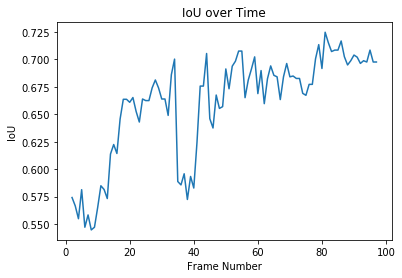

Note: The Tracked Box is in Red; The Detected Box is in Green


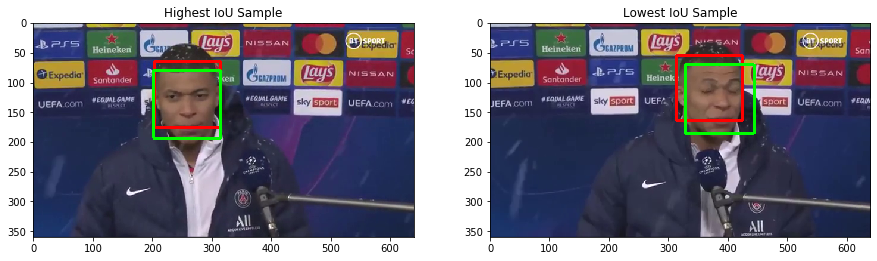

In [12]:
cap = cv2.VideoCapture('Q5.mp4')
ret, frame = cap.read()

face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
face_boxes = face_detector.detectMultiScale(frame)

if len(face_boxes) == 0:
    print('No Face Detected!')
    assert(False)
track_window = face_boxes[0]
(x, y, w, h) = track_window 
roi = frame[y:y + h, x:x + w]
hsv_roi =  cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)

mask = cv2.inRange(hsv_roi, np.array((0., 60.,32.)), np.array((180.,255.,255.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist, roi_hist, 0, 255, cv2.NORM_MINMAX)

term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )

prev_window = (x, y, w, h)
IoU_axis = []
lowest_frame, lowest_IoU = None, 1
highest_frame, highest_IoU = None, 0
low_frames = []
num_frame = 1
while True:
    ret, frame = cap.read() 
    if ret == True:   
        num_frame += 1
        # convert to HSV
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        # histogram back projection using roi_hist 
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
        # use meanshift to shift the tracking window
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)

        # detect the bounding box in each frame
        face_boxes = face_detector.detectMultiScale(frame)
        # select the face with highest IoU between the previous frame 
        if len(face_boxes) == 0:
            print('No Face Detected!')
            assert(False)
        max_iou, optimal_window = 0, None
        for face_coord in face_boxes:
            x, y, w, h = face_coord
            new_iou = _get_IoU(face_coord, prev_window)
            if new_iou > max_iou:
                max_iou = new_iou
                optimal_window = face_coord
        prev_window = optimal_window
        # calculate the IoU between the selected face and meanshift tracking
        iou = _get_IoU(optimal_window, track_window)

        # store info for plotting
        IoU_axis.append(iou)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if iou > highest_IoU:
            highest_IoU = iou
            x, y, w, h = track_window
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)
            x, y, w, h = optimal_window
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
            highest_frame = frame
        if iou < lowest_IoU:
            lowest_IoU = iou
            x, y, w, h = track_window
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)
            x, y, w, h = optimal_window
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
            lowest_frame = frame
        if iou < 0.6:
            x, y, w, h = track_window
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)
            x, y, w, h = optimal_window
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
            low_frames.append(frame)
    else:
        break
# plot IoU over time 
plt.plot(np.arange(2, num_frame + 1), IoU_axis)
plt.xlabel('Frame Number')
plt.ylabel('IoU')
plt.title('IoU over Time')
plt.show()
# plot the highest/lowest smaple frame
fig, axes = plt.subplots(1, 2, figsize=(15, 13))
axes[0].imshow(highest_frame)
axes[1].imshow(lowest_frame)
axes[0].set_title('Highest IoU Sample')
axes[1].set_title('Lowest IoU Sample')
print('Note: The Tracked Box is in Red; The Detected Box is in Green')

### We pick 70% and 60% as the threshold instead of 50% and 10% ###

In [13]:
IoUs = np.array(IoU_axis)
print(f'The percentage of frames in which the IoU > 50% is {len(np.where(IoUs > 0.5)[0]) / len(IoUs)}')
print(f'The percentage of frames in which the IoU > 70% is {len(np.where(IoUs > 0.7)[0]) / len(IoUs)}')

The percentage of frames in which the IoU > 50% is 1.0
The percentage of frames in which the IoU > 70% is 0.17708333333333334


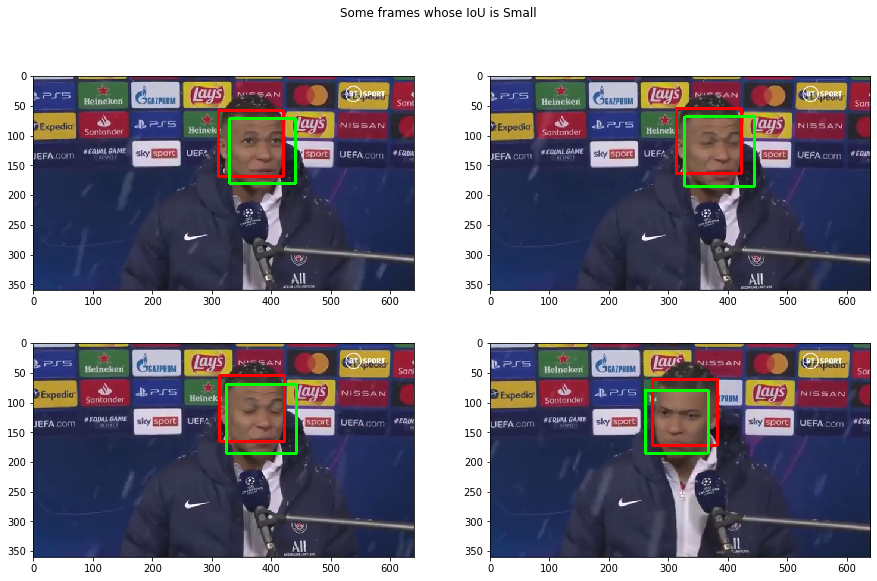

In [14]:
# print sample frames of low IoU
stride = len(low_frames) // 4
fig, axes = plt.subplots(2, 2, figsize=(15, 9))
fig.suptitle('Some frames whose IoU is Small')
axes[0, 0].imshow(low_frames[0])
axes[0, 1].imshow(low_frames[stride])
axes[1, 0].imshow(low_frames[2 * stride])
axes[1, 1].imshow(low_frames[3 * stride]);

Since the red boxes is generated by mean shift tracking and green is the detected boxes. After having a look at sample frames of IoU is small, the Viola-Jones detection gives better results.<br/>
A possible reason is that Mbappe has similar face and hair color, which makes their difference in hue less and hard to distinguish for the mean shift algorithm. Also note the background has the similar hue, and mean shift is not robust against to it.

## 5.2 Implement a Simple Variation ##

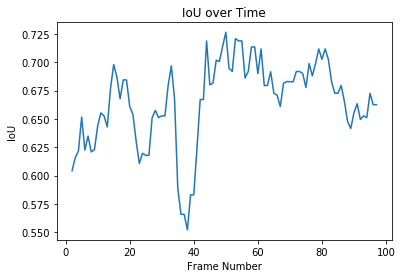

Note: The Tracked Box is in Red; The Detected Box is in Green


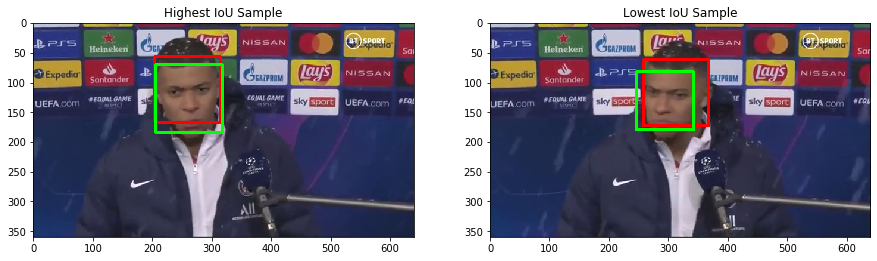

In [15]:
cap = cv2.VideoCapture('Q5.mp4')
ret, frame = cap.read()
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') 
face_boxes = face_detector.detectMultiScale(frame) 
if len(face_boxes)==0:
    print('no face detected')
    assert(False)
x, y, w, h = face_boxes[0]
roi = frame[y:y + h, x: x + w]
# roi to gradient
roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
roi = cv2.GaussianBlur(roi, (5, 5), 1)
I_x = cv2.Sobel(roi, cv2.CV_64F, 1, 0, ksize=5)
I_y = cv2.Sobel(roi, cv2.CV_64F, 0, 1, ksize=5)
magnitude = np.zeros_like(I_x)
angle = np.zeros_like(I_x, dtype='uint8')  # range 0-360 degrees
cv2.cartToPolar(I_x, I_y, magnitude, angle, angleInDegrees=True)

mask = cv2.inRange(magnitude, np.max(magnitude) * .1, np.inf)
gradient_hist = cv2.calcHist([angle], [0], mask, [24], [0, 360])
cv2.normalize(gradient_hist, gradient_hist, 0, 255, cv2.NORM_MINMAX)

prev_window = face_boxes[0]
IoU_axis = []
lowest_frame, lowest_IoU = None, 1
highest_frame, highest_IoU = None, 0
while True:
    ret, frame = cap.read() 
    if ret:
        frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        # frame_gray = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
        
        dst = cv2.calcBackProject([frame_hsv], [0], gradient_hist, [0, 360], 1)
        ret, track_window = cv2.meanShift(dst, track_window, term_crit)
        
        # detect the bounding box in each frame
        face_boxes = face_detector.detectMultiScale(frame)
        # select the face with highest IoU between the previous frame 
        if len(face_boxes) == 0:
            print('No Face Detected!')
            assert(False)
        max_iou, optimal_window = 0, None
        for face_coord in face_boxes:
            x, y, w, h = face_coord
            new_iou = _get_IoU(face_coord, prev_window)
            if new_iou > max_iou:
                max_iou = new_iou
                optimal_window = face_coord
        prev_window = optimal_window
        
        # calculate the IoU between the selected face and meanshift tracking
        iou = _get_IoU(optimal_window, track_window)
        IoU_axis.append(iou)
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        if iou > highest_IoU:
            highest_IoU = iou
            x, y, w, h = track_window
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)
            x, y, w, h = optimal_window
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
            highest_frame = frame
        if iou < lowest_IoU:
            lowest_IoU = iou
            x, y, w, h = track_window
            cv2.rectangle(frame, (x, y), (x + w, y + h), (255, 0, 0), 3)
            x, y, w, h = optimal_window
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 3)
            lowest_frame = frame
    else:
        break

# plot IoU over time 
plt.plot(np.arange(len(IoU_axis)) + 2, IoU_axis)
plt.xlabel('Frame Number')
plt.ylabel('IoU')
plt.title('IoU over Time')
plt.show()
# plot the highest/lowest smaple frame
fig, axes = plt.subplots(1, 2, figsize=(15, 13))
axes[0].imshow(highest_frame)
axes[1].imshow(lowest_frame)
axes[0].set_title('Highest IoU Sample')
axes[1].set_title('Lowest IoU Sample')
print('Note: The Tracked Box is in Red; The Detected Box is in Green')

In [16]:
IoUs = np.array(IoU_axis)
print(f'The percentage of frames in which the IoU > 50% is {len(np.where(IoUs > 0.5)[0]) / len(IoUs)}')
print(f'The percentage of frames in which the IoU > 70% is {len(np.where(IoUs > 0.7)[0]) / len(IoUs)}')

The percentage of frames in which the IoU > 50% is 1.0
The percentage of frames in which the IoU > 70% is 0.15625
